In [230]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

fs=24
lw=4

rms = lambda x: np.sqrt(np.mean(np.square(x))) 

# Midterm Exam

## Python Problem 3 [Problem 3 part e]: Least Squares Placement

### Problem Setup

Let us recall the problem setup. The vectors $p_{1}, \ldots, p_{N}$, each in $\mathbb{R}^2$ represent the locations of $N$ factories. 
There are two types of factories: "square" factories and "circle" factories. The first $K$ factories are square factories, whose locations are fixed and given.  Our goal in the placement problem to choose the locations of the last $N-K$ factories i.e the circle factories. 

Our choice of the locations is guided by an undirected graph; an edge between two factories means we would like them to be close to each other. In least squares placement, we choose the locations $p_{K+1}, \ldots, p_{N}$ so as to minimize the sum of the squares of the distances between factories connected by an edge,
where the $L$ edges of the graph are given by the set $E$. For a specific location of square factories $p_1 \ldots p_K$, we can frame our task as solving the following optimization:
$$
g(p_1, \ldots p_K) = \min_{p_{K+1}, \ldots p_N} \sum_{(i,j)\in E}\|p_i-p_j\|^2
$$

In the code below, we have set up a specific instance of this problem.

In [231]:
N, K, L = 10, 5, 13

edges = [(1,6), (2,6), (5,6), (1,7), (4,7),
        (2,8), (3,8), (3,9), (5,9), (5,10), (7,9), (6, 10), (7,10)]


p1 = np.array([0.55,0.15])
p2 = np.array([0,0])
p3 = np.array([0,1])
p4 = np.array([1,1])
p5 = np.array([1,0])

fixed_locs = [p1, p2, p3, p4, p5]

### Solving the problem

In parts (b) and (c), you reduced the problem to a least squares problem. Here, we set up and solve the least squares problem to obtain the optimal locations for the circle factories.

In [232]:
#TODO: Create Incidence Matrix
B = np.zeros((N, L))
for i in range(L):
    x = edges[i]
    leave = x[0]-1
    enter = x[1]-1
    edge = i
    B[leave, i] = 1;
    B[enter, i] = -1;
    
Bw = B[K:]
Bf = B[:K]
uf = np.zeros(K)
vf = np.zeros(K)
for i in range(K):
    uf[i] = fixed_locs[i][0]
    vf[i] = fixed_locs[i][1]

In [233]:
#TODO: Set up least squares problem
b = np.zeros((26,))
b[0:13] = np.matmul(np.transpose(Bf), uf)
b[13:26] = np.matmul(np.transpose(Bf), vf)

A = np.zeros((2*L, 2*K))
for i in range(np.transpose(Bw).shape[0]):
    for j in range(np.transpose(Bw).shape[1]):
        A[i, j] = np.transpose(Bw)[i, j]
        A[i+L, j+K] = np.transpose(Bw)[i, j]        

In [234]:
#TODO: Solve least squares problem.
#Hint: np.linalg.lstsq() might be helpful here.
x = np.linalg.lstsq(A, b, rcond=None)[0]

u_m, v_m = x[0:5], x[5:] # contains the solution to the location placement problem

### Plotting the solution

Now, we want to plot the locations we solved for above. Show the graph edges as lines connecting the locations.

Below the variables `u_m` and `v_m` should contain the solution to the locations from above. 

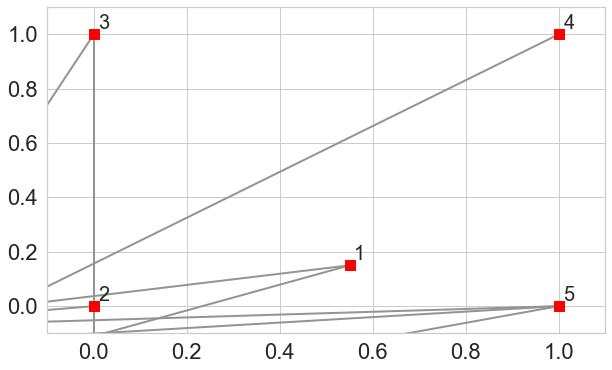

In [235]:
chosen_locs = []
for i in range(len(u_m)):
    new_loc = [u_m[i], v_m[i]]
    chosen_locs.append(new_loc)
    
fixed_locs, chosen_locs = np.array(fixed_locs), np.array(chosen_locs)
all_locs = np.concatenate((fixed_locs, chosen_locs))

plt.figure(figsize=(10,6))
plt.tick_params(labelsize=fs-2)

for i in range(len(all_locs)):
    plt.annotate(str(i+1), (all_locs[i, 0] + 0.01, all_locs[i, 1]+0.02), fontsize=fs-4,zorder=2)

for (source, dest) in edges:
    source_x, source_y = all_locs[source - 1][0], all_locs[source - 1][1]
    dest_x, dest_y = all_locs[dest - 1][0], all_locs[dest - 1][1]
    plt.plot([source_x, dest_x], [source_y, dest_y],color = 'xkcd:grey', linewidth=2,zorder=1)
    
plt.scatter(fixed_locs[:, 0], fixed_locs[:, 1], marker = 's', color = 'red', s = 100,zorder=2)
plt.scatter(chosen_locs[:, 0], chosen_locs[:, 1], s = 120,zorder=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.savefig("problem3e_plot.png")

## Python Problem 4 [Problem 4 part c]: Recursive Least squares
You are asked to implement recursive least squares using the formula given in the following equations:
\begin{align}
    \hat{\theta}_{m+1}&=\hat{\theta}_m+R_{m+1}^{-1}x^{(m+1)}(y^{(m+1)}-(x^{(m+1)})^\top\hat{\theta}_m)\label{eq:theta}\\
    R_{m+1}&=R_{m}+x^{(m+1)}(x^{(m+1)})^\top\label{eq:R}
\end{align}
where 
$$R_{m+1}:=\sum_{k=1}^{m+1}x^{(k)}(x^{(k)})^\top.$$

You will test it on a randomly generated data set, and on the housing data set. The housing data set is provided with the exam materials but you can find it on the course website [here](https://ratlifflj.github.io/S22-445/jpyntbks/module2/data/housing.cvs).

### Part 1 [Random Least Squares Instance]
#### Part 1a
Implement the recursive least squares method as a function. It should take in the following as inputs:
1.  size of the data set over which you will run the algorithm $n$,
2.  an initial value for $R_{0}$ and an initial value for $\hat{\theta}_0$, 
3.  The data $X$ you will use to recursively estimate the value of $\theta$
4.  $N$ which is the number of features you use to compute $R_0$

It should return a list of $R_m$ and $\hat{\theta}_m$ values. 

Towards this end, you will need generate a random least squares instance (the code is given below). Then to ensure $R_0$ is invertible, we will take the first $N=500$ rows of $X$ and compute
$$R_0=\sum_{i=1}^Nx^{(i)}(x^{(i)})^\top\quad\text{and}\quad \hat{\theta}_0=(R_0)^{-1}\sum_{i=1}^Nx^{(i)}y^{(i)}.$$
This means that since $X\in \mathbb{R}^{m\times 2}$ (we have two features and $m=5000$ data points), we have $n=m-N$. That is, we will run the recursive least squares method for the remaining feature vectors. 

You are encouraged to play around with the size of the data $m$, the number $N$ of initial feature vectors you take to compute $R_0$, and the random seed. However, you do not have to submit anything on that. Just submit the notebook (and printed pdf) for the values described above. 

In [236]:
np.random.seed(20)
N=500
m=5000
n=m-N

### Generate a least squares instance
x = np.linspace(0, 1, m)
theta_true=[1,5, 3] # true theta, i.e. your recursive least squares estimate should converge to this
y = theta_true[0]+x*theta_true[1]+theta_true[2]*x**2+np.random.normal(loc=0.0,scale=1.5, size=len(x))

# turn y into a column vector
y = y[:, np.newaxis]

# assemble the data matrix X
# this is just the univariate fit from Mod2
X = np.vstack([np.vstack([np.ones(len(x)),x]), x**2]).T
print("dimension of X : ", np.shape(X))

## write your code to compute R_0
R0= np.zeros((len(X[0]), (len(X[0])))) # enter code here
for i in range(N):
    xi = X[i].reshape(len(X[i]), 1)
    res = np.matmul(xi, np.transpose(xi))
    R0 = R0 + res
print("inv(R0) : \n", la.inv(R0))

## here we can print out the condition number (this will be discussed in detail in Mod3)
## the condition number is a measure of how "invertible" a matrix is. You want it to be small
## if you play around with the size of N relative to m, you can see how adding more vectors effects the condition number
print(la.cond(R0))

## write your code to compute theta_0
R0i = la.inv(R0)
res = 0
for i in range(N):
    xi = X[i].reshape(len(X[i]), 1)
    res += np.matmul(xi, y[i])
theta0 = np.matmul(R0i, res) #enter code here
print("initial theta : ", theta0)

def RLSQ(theta0, R0, n, N=N):
    ## Fill in code here to implement recursive least squares
    thetas = []
    Rs = []
    thetas.append(theta0)
    Rs.append(R0)
    for i in range(N+1, N+n):
        curr = i-N
        Xcurr = X[curr].reshape(len(X[curr]), 1)
        r = Rs[curr-1] + np.matmul(Xcurr, np.transpose(Xcurr))
        Rs.append(r)
        ri = la.inv(r)
        rx = np.matmul(ri, Xcurr)
        inner = y[curr] - np.matmul(np.transpose(Xcurr), thetas[curr-1])
        t = thetas[curr-1] + np.matmul(rx, inner)
        thetas.append(t)
    return thetas, Rs

# Run RLSQ
thetas,Rs=RLSQ(theta0,R0,n)   

dimension of X :  (5000, 3)
inv(R0) : 
 [[ 1.78567646e-02 -7.14841377e-01  5.96178185e+00]
 [-7.14841377e-01  3.82415695e+01 -3.59071657e+02]
 [ 5.96178185e+00 -3.59071657e+02  3.59719281e+03]]
1821083.3596376535
initial theta :  [  0.89357079  13.35265552 -83.67996544]


#### Part 1b Compute the error and plot it
Run least squares on the random data instance and take the output of $\hat{\theta}_m$ and computer the error for each iterate:
$$\|\theta^{\tt lsq}-\hat{\theta}_{m}\|_2\quad \text{for each}\ m\in\{0,\ldots, n\}$$
where $\theta^{\tt lsq}$ is the least squares approximate solution. 
And, then plot it. Print out the least squares solution (e.g., obtained with numpy or the least squares formula) you computed and print out the recursive least squares solution you computed.

True theta value                 :  [1, 5, 3]
Numpy Least Squares Solution     :  [0.99850271 5.05181774 2.92158339]
Recursive Least squares solution :  [0.9950145  5.14489841 2.77340016]


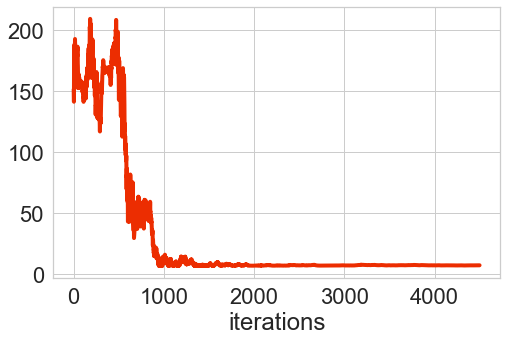

In [237]:
# Compute the actual least squares theta
# you will need this to compute the error
theta_lsq= np.linalg.lstsq(X, y, rcond=None)[0] # compute least squares solution using analytic formula or numpy.linalg

error= []
for i in range(len(thetas)):
    err = np.linalg.norm(theta_lsq-thetas[i]) #compute the error using the output of RLSQ (thetas)
    error.append(err)


# Plot it
plt.figure(figsize=(8,5))
plt.tick_params(labelsize=fs-2)
plt.plot(error, linewidth=lw, color='xkcd:tomato red')
plt.xlabel('iterations', fontsize=fs)

# print out values
print("True theta value                 : ", theta_true)
print("Numpy Least Squares Solution     : ", theta_lsq.T[0])
print("Recursive Least squares solution : ", thetas[-1])

#### Part 1c [Plot the data and the estimated line]
Now plot the line you estimated with the RLSQ function and the data.

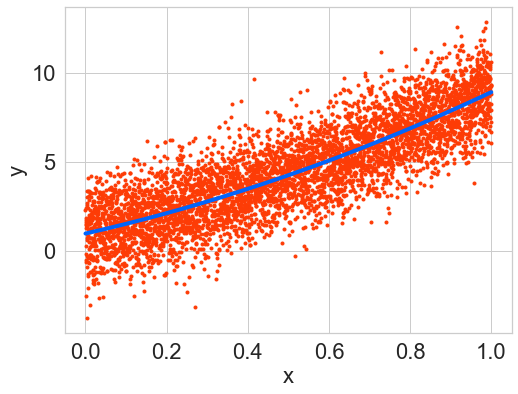

In [238]:
finalval = thetas[len(thetas)-1]
line= np.matmul(X, finalval) # fill in code to compute f(x) using the final value of hat{theta}_m computed from RLSQ

plt.figure(figsize=(8,6))
plt.tick_params(labelsize=fs-2)
plt.xlabel('x',fontsize=fs-2)
plt.ylabel('y',fontsize=fs-2)
plt.plot(x,y, '.', color='xkcd:red orange')
plt.plot(x,line, linewidth=lw, color='xkcd:bright blue')

### Part 2 [Housing Data]
Now you will run your recursive least square method on the housing data. First load it, and then using the price as $y$, and area, number of beds, and a constant as features, create a least squares problem. Run your method on it, and plot the error as in part 1b.

In [240]:
np.random.seed(20)
file_loc= "../lecture-ntbks/data/housing.csv" # enter the location of housing.csv as a string. For example "./housing.csv" if its in the current directory.
# for my own directory 
# file_loc = "C:/Users/dswhi/OneDrive/Documents/UW Junior Year/Spring Quarter/EE 445/housing.csv"

df=pd.read_csv(file_loc)


price = df["price"]; 
area  = np.asarray(df["area"]); 
beds  = np.asarray(df["beds"]);

# show head of df
df.head()

,area,baths,beds,condo,location,price
0,0.941,2,2,1,2,94.905
1,1.146,2,3,0,2,98.937
2,0.909,2,3,0,2,100.309
3,1.289,2,3,0,3,106.250
4,1.020,1,3,0,3,107.502


m :  774
n :  769
inv(R0) : 
 [[15.11084161 -7.97323183 -2.30401523]
 [-7.97323183 12.43873921 -1.86581088]
 [-2.30401523 -1.86581088  1.52987163]]
1105.5898873139029
initial theta :  [73.51055737  7.34078414  7.24338238]
(3,)
769
Numpy Least Squares Solution     :  [ 54.4016736  148.7250726  -18.85335788]
Recursive Least squares solution :  [ 53.33809023 149.44027312 -18.97609885]


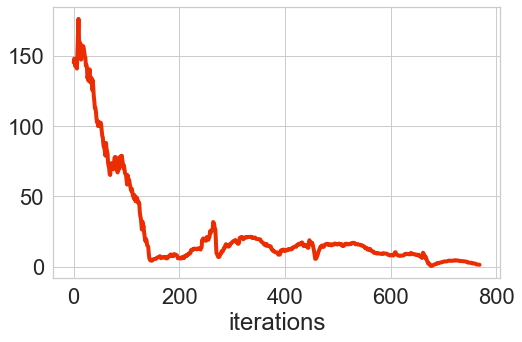

In [241]:
X = np.ones((df.shape[0], 3)) # create the data matrix using a vector of 1's for the constant, areas and beds
X[:,1] = area
X[:,2] = beds
y = price.to_numpy()
y = y[:, np.newaxis]

# set m to the number of rows of X
m=np.shape(X)[0]
print("m : ", m)
# set N
N=5
# define number of iterations to run RLSQ
n=m-N
print("n : ", n)

# Compute R0 using the first N features
R0= np.zeros((len(X[0]), (len(X[0])))) # Fill this in 
for i in range(N):
    xi = X[i].reshape(len(X[i]), 1)
    res = np.matmul(xi, np.transpose(xi))
    R0 = R0 + res
print("inv(R0) : \n", la.inv(R0))

print(la.cond(R0))

# compute theta0 using R0
R0i = la.inv(R0)
res = 0
for i in range(N):
    xi = X[i].reshape(len(X[i]), 1)
    res += np.matmul(xi, y[i])
theta0 = np.matmul(R0i, res) # fill this in
print("initial theta : ", theta0)

# Run RLSQ
thetas,Rs=RLSQ(theta0,R0,n, N=N)

# Compute the actual least squares theta
theta_lsq = np.linalg.lstsq(X, y, rcond=None)[0] # fill this in
theta_lsq = np.reshape(theta_lsq, (len(theta_lsq)))
print(np.shape(theta_lsq))

# compute the error and plot it
error= [] # Fill this in 
for i in range(len(thetas)):
    err = np.linalg.norm(theta_lsq-thetas[i]) #compute the error using the output of RLSQ (thetas)
    error.append(err)
print(len(error))
plt.figure(figsize=(8,5))
plt.tick_params(labelsize=fs-2)
plt.plot(error, linewidth=lw, color='xkcd:tomato red')
plt.xlabel('iterations', fontsize=fs)


print("Numpy Least Squares Solution     : ", theta_lsq)
print("Recursive Least squares solution : ", thetas[-1])
    

